In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import modules.evaluate as evaluate
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import kendalltau
import modules.random_graph as random_graph
import math
import random




modelLoads= ["AA", "AB", "BA", "BB", "infer2018"]
weightModels= ["degree", "gravity", "identical"]
randomGraphs= ["ER", "BA", "WS", "RGG"]
seeds= [10, 11, 12, 13, 14]
strains= [1, 2, 3, 4]
denses= [0, -1, -2, -3, -4]
nodes= [50, 100, 200, 400]
intenses= [0, 1, 2, -1]

identicalfs= [2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1]# except 1e-2

commands1=set()
linuxThread= 3

In [2]:
def continious_to_sparcity(my_array, top= 400):
    # Flatten the array to a 1D array
    flat_array = my_array.flatten()

    # Sort the flattened array in descending order
    sorted_indices = np.argsort(flat_array)[::-1]

    # Set the top 400 elements to 1 and the rest to 0
    flat_array[sorted_indices[:top]] = 1
    flat_array[sorted_indices[top:]] = 0

    # Reshape the modified 1D array back to the original shape
    result_array = flat_array.reshape(my_array.shape)
    return result_array

def continious_to_sparcity_cols(my_matrix, topRow= 8):

    result_matrix = np.zeros_like(my_matrix)
    indices = np.argsort(my_matrix, axis=1)[:, -topRow:]  # Get indices of top 8 elements in each row
    row_indices = np.arange(my_matrix.shape[0])[:, None]  # Row indices to broadcast
    result_matrix[row_indices, indices] = 1
    
    return result_matrix

def analyse_signal(signal):
    maxIndex = np.argmax(signal, axis= 2)
    signalCombine= signal.reshape(signal.shape[0], signal.shape[1]*signal.shape[2])
    meanV= maxIndex.mean()
    varV= np.var(maxIndex)
    simMatrix= cosine_similarity(signalCombine)
    simMatrixSumAVg= simMatrix.sum()/signal.shape[0]/signal.shape[0]
    return meanV, varV, simMatrixSumAVg

def scatter_points(x, y, xLabel="x", yLabel="y"):
    plt.scatter(x, y)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    pearson_corr = np.corrcoef(x, y)[0, 1]
    spearman_corr = np.corrcoef(np.argsort(x), np.argsort(y))[0, 1]
    kendall_corr, _ = kendalltau(x, y)
    print(f"Pearson correlation: {pearson_corr:.2f}, spearma correlation: {spearman_corr:.2f},  kendall correlation: {kendall_corr:.2f}")


(100, 4, 47)


(24.145, 61.568975, 0.2879723876953125)

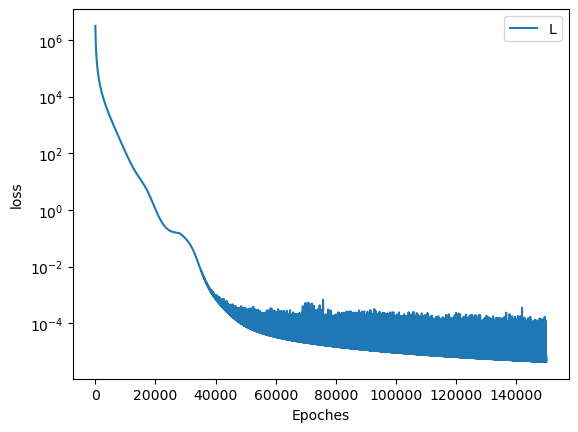

In [3]:
identicalf= 0.01

node= 100

strain= 4

#AA_RGG_identical_12_2_-1_0_100_10.0_150000
#AA_ER_identical_13_4_-1_0_100_10.0_150000
#AA_WS_identical_11_1_-1_0_100_10.0_150000
#AA_WS_identical_11_4_-1_0_100_10.0_150000

fileName= f"results/AA/AA_RGG_identical_{13}_{strain}_-1_0_100_{identicalf*1000}_150000.npz"
IMatrix= torch.eye(node, device= "cpu")
npzfile = np.load(fileName)
loss= npzfile['loss']
taus= npzfile["taus"]
signal= npzfile['signal']

plt.plot(loss)
plt.yscale("log")
plt.xlabel("Epoches")
plt.ylabel("loss")
plt.legend("Loss")


print(signal.shape)

analyse_signal(signal)

In [5]:
#AA_WS_identical_11_4_-1_0_100_10.0_150000

identicalf= 0.01
node= 100
#Is - jaccard index
cosinesL= []
spectralsL= []
edgesL= []
jaccardsL= []
meanVL= [] 
varVL= [] 
simMatrixSumAVgL= []
for randomGraph in randomGraphs:
    for dense in denses:
        cosines= 0
        spectrals= 0
        edges= 0
        jaccards= 0
        for seed in seeds:
            try:
                fileName= f"results/AA/AA_{randomGraph}_identical_{seed}_{strain}_-1_{dense}_{node}_{identicalf*1000}_150000.npz"
                IMatrix= torch.eye(node, device= "cpu")
                npzfile = np.load(fileName)
            except:
                print(fileName)
                continue
            # Access the arrays in the NPZ file
            Awnp= npzfile['A']
            PreAnp= npzfile['Apre']
            signal= npzfile['signal']
            meanV, varV, simMatrixSumAVg= analyse_signal(signal)
            meanVL.append(meanV)
            varVL.append(varV)
            simMatrixSumAVgL.append(simMatrixSumAVg)
            Aw = torch.tensor(Awnp)
            PreA = torch.tensor(PreAnp)
            links= int(torch.sum(Aw)/identicalf)  
            Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
            PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))+IMatrix
            cosinesL.append(evaluate.cosine_similarity(Aw, PreA).item())
            spectralsL.append(evaluate.spectral_analysis(Aw, PreA).item())
            edgesL.append(evaluate.recall(Aws, PreAs).item())
            jaccardsL.append(evaluate.jaccard_index(Aws, PreAs).item())

Pearson correlation: 0.74, spearma correlation: 0.54,  kendall correlation: 0.58


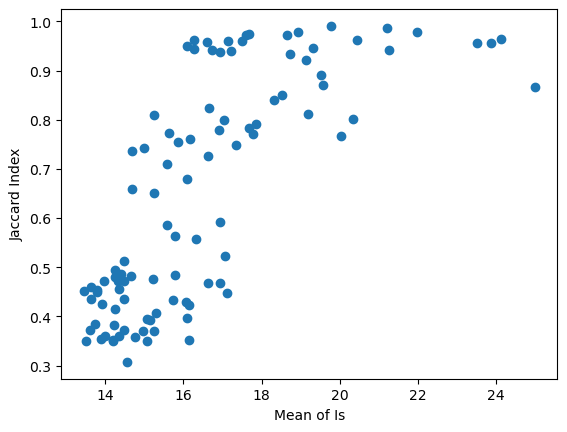

In [6]:
scatter_points(meanVL, jaccardsL, "Mean of Is","Jaccard Index" )

Pearson correlation: 0.69, spearma correlation: 0.63,  kendall correlation: 0.73


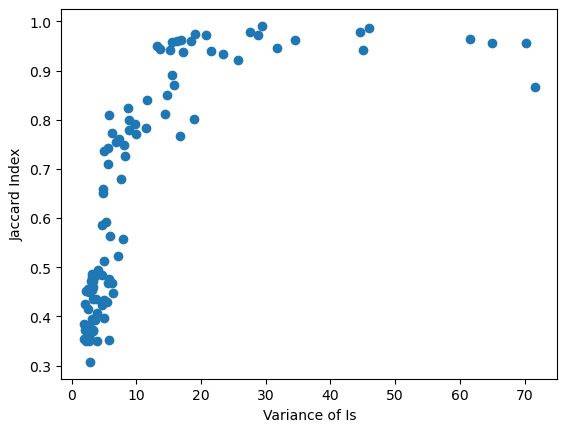

In [7]:
scatter_points(varVL, jaccardsL, "Variance of Is", "Jaccard Index" )

Pearson correlation: -0.94, spearma correlation: -0.72,  kendall correlation: -0.74


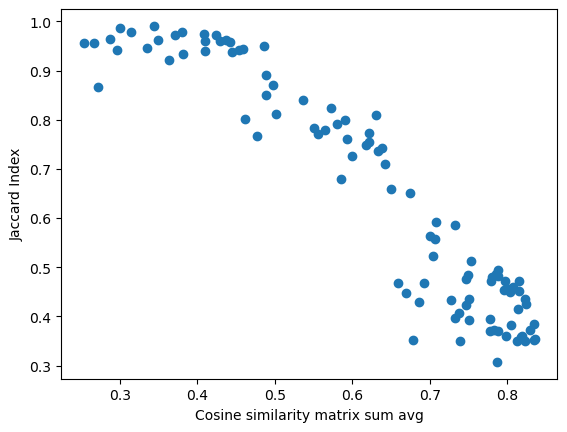

In [8]:
scatter_points(simMatrixSumAVgL, jaccardsL, "Cosine similarity matrix sum avg", "Jaccard Index" )

In [201]:
#train svm classier
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.svm import SVR  # For SVM regression

model = SVR(kernel='linear')  # Adjust kernel as needed
x_train_np= np.stack(meanVL)
y_train_np= np.stack(varVL)
z_train_np= np.stack(simMatrixSumAVgL)
g_train_np= np.stack(jaccardsL)
model.fit(np.stack([x_train_np, y_train_np, z_train_np], axis=1), g_train_np)

g_pred_np = model.predict(np.stack([x_train_np, y_train_np, z_train_np], axis=1))

print(np.mean(np.abs(g_train_np-g_pred_np)))
print(np.var(np.abs(g_train_np-g_pred_np)))

0.0648166367721555
0.0019991868151114536


In [214]:
import modules.random_graph as random_graph
import modules.pramameters as pramameters
import modules.utils as utils
import modules.weight as weight
import modules.A_mat as A_mat
import modules.population as population
import modules.simulation as simulation
import argparse



#Changeable parameters 
parser = argparse.ArgumentParser(description='Topology fitting parameters')
pramameters.add_arguments(parser)
paras= pramameters.read_arguments(parser)
#preset
paras.modelLoad= "AA"
paras.randomGraph= "ER"
paras.weightModel= "identical"
paras.epoches= 100000
paras.intense= -1
paras.seed= 13
paras.plot= "spring"
paras.strains= 4
paras.dense= 0
paras.identicalf= 0.01
paras.n= 100

if paras.dense<=0:
    paras.dense= int(math.log(paras.n))-paras.dense
    print(paras.dense)

A, G= random_graph.get_BA_random_contact(paras.n, paras.dense-2)

P= population.population(paras.n)

Zmat= A_mat.create_A_mat(Aw, P)
Aw= weight.identical_model(A, paras.identicalf)

R0s_taus= [[random.uniform(paras.R0Mean-paras.R0Std, paras.R0Mean+paras.R0Std), 
            random.uniform(paras.tauMean-paras.tauStd, paras.tauMean+paras.tauStd)] for _ in range(40)]
paras.R0s=  [ R0s_taus[i][0] for i in range(40)]
paras.taus= [ R0s_taus[i][1] for i in range(40)]

deltaSsTensor= simulation.multi_strains(G, paras, Zmat, intense= paras.intense, lower= 50)
deltaSs= deltaSsTensor.sum(dim= -1, keepdim= True)
propition= deltaSsTensor/(deltaSs+1e-8)
deltaSs= deltaSs.squeeze()#(1, 2, 20), dim of nodes, dim of heads, dim of signal
divide= deltaSsTensor.transpose(1, 2)

meanV, varV, simMatrixSumAVg= analyse_signal(divide.numpy())

print(meanV, varV, simMatrixSumAVg)
print(model.predict(np.array([[meanV, varV, simMatrixSumAVg]])))

4
19.815 14.290774999999998 0.5373341796875
[0.72915588]


In [195]:
# from datetime import datetime
# timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# # Specify the file path
# file_path = f"graphs/er_{timestamp}.npy"
# # Save the matrix to a file
# np.save(file_path, A.numpy())
# print(f"NumPy matrix saved to file: {file_path}")

NumPy matrix saved to file: graphs/er_2024-01-02_10-10-20.npy


In [55]:

identicalf= 0.01
node= 50
strain= 4

#Performance on different models

for randomGraph in randomGraphs:
    cosinesList= []
    spectralsList= []
    edgesList= []
    jaccardsList= []
    for modelLoad in modelLoads:
        cosines= 0
        spectrals= 0
        edges= 0
        jaccards= 0
        minus= 0
        for seed in seeds:
            try:
                if modelLoad=="AA":
                    fileName= f"results/AA/AA_{randomGraph}_identical_{seed}_{strain}_0_8_50_{identicalf*1000}_140000.npz"
                else:
                    fileName= f"results/{modelLoad}/{modelLoad}_{randomGraph}_identical_{seed}_{strain}_0_100000.npz"
                IMatrix= torch.eye(node, device= "cpu")
                npzfile = np.load(fileName)
            except:
                #print(fileName)
                minus+=1
                continue
            # Access the arrays in the NPZ file
            Awnp= npzfile['A']
            PreAnp= npzfile['Apre']
            Aw = torch.tensor(Awnp)
            PreA = torch.tensor(PreAnp)
            links= int(torch.sum(Aw)/identicalf)  
            Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
            PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))+IMatrix
            cosines+= evaluate.cosine_similarity(Aw, PreA)
            spectrals+= evaluate.spectral_analysis(Aw, PreA)
            edges+= evaluate.edge_correctness(Aws, PreAs)
            jaccards+= evaluate.jaccard_index(Aws, PreAs)
        cosines/= len(seeds)-minus
        spectrals/= len(seeds)-minus
        edges/= len(seeds)-minus
        jaccards/= len(seeds)-minus
        cosinesList.append(f"{cosines:.2f}")
        spectralsList.append(f"{spectrals:.2f}")
        edgesList.append(f"{edges:.2f}")
        jaccardsList.append(f"{jaccards:.2f}")
        #print(f"{cosines:.2f}\t{spectrals:.2f}\t{edges:.2f}\t{jaccards:.2f}", end="\t")
    print("\t".join(cosinesList)+"\t"+"\t".join(spectralsList)+"\t"+"\t".join(edgesList)+"\t"+"\t".join(jaccardsList))
    #print()

0.74	0.55	0.33	0.56	0.57	0.51	0.60	0.49	0.46	0.58	0.69	0.38	0.38	0.56	0.57	0.52	0.23	0.23	0.39	0.40
0.77	0.51	0.33	0.53	0.55	0.49	0.63	0.54	0.49	0.53	0.74	0.35	0.37	0.57	0.58	0.59	0.21	0.23	0.40	0.41
0.77	0.56	0.34	0.60	0.61	0.70	0.59	0.67	0.68	0.64	0.75	0.39	0.39	0.62	0.61	0.60	0.25	0.24	0.45	0.44
0.93	0.64	0.47	0.58	0.60	0.93	0.74	0.79	0.85	0.82	0.97	0.52	0.52	0.74	0.75	0.95	0.35	0.35	0.59	0.60


In [30]:
#AA_WS_identical_11_4_-1_0_100_10.0_150000

identicalf= 0.01
node= 100
random.seed(100001)
dense= int(math.log(node))
CompareWithRandom= False

#Performance on different strains new

for randomGraph in randomGraphs:
    cosinesList= []
    spectralsList= []
    edgesList= []
    jaccardsList= []
    hammingList= []
    for strain in strains:
        cosines= 0
        spectrals= 0
        edges= 0
        jaccards= 0
        hammings= 0
        for seed in seeds:
            try:
                fileName= f"results/AA/AA_{randomGraph}_identical_{seed}_{strain}_-1_0_{node}_{identicalf*1000}_150000.npz"
                IMatrix= torch.eye(node, device= "cpu")
                npzfile = np.load(fileName)
            except:
                print(fileName)
                continue
            # Access the arrays in the NPZ file
            Awnp= npzfile['A']
            PreAnp= npzfile['Apre']
            if CompareWithRandom:
                A, _= random_graph.get_ER_random_contact(node, dense, shuffle= True)
                PreAnp= A.numpy()

            Aw = torch.tensor(Awnp)
            PreA = torch.tensor(PreAnp)
            links= int(torch.sum(Aw)/identicalf)  
            Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
            PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))+IMatrix
            cosines+= evaluate.cosine_similarity(Aw, PreA)
            spectrals+= evaluate.spectral_analysis(Aw, PreA)
            edges+= evaluate.recall(Aws, PreAs)
            jaccards+= evaluate.jaccard_index(Aws, PreAs)
            hammings+= evaluate.normalized_hamming_distance(Aws, PreAs)
        cosines/= len(seeds)
        spectrals/= len(seeds)
        edges/= len(seeds)
        jaccards/= len(seeds)
        hammings/= len(seeds)
        cosinesList.append(f"{cosines:.2f}")
        spectralsList.append(f"{spectrals:.2f}")
        edgesList.append(f"{edges:.2f}")
        jaccardsList.append(f"{jaccards:.2f}")
        hammingList.append(f"{hammings:.2f}")
        #print(f"{cosines:.2f}\t{spectrals:.2f}\t{edges:.2f}\t{jaccards:.2f}", end="\t")
    print("\t".join(cosinesList)+"\t"+"\t".join(spectralsList)+"\t"+"\t".join(edgesList)+"\t"+"\t".join(jaccardsList)+"\t"+"\t".join(hammingList))
    #print()
    #print()

0.31	0.50	0.58	0.65	0.33	0.28	0.26	0.20	0.31	0.45	0.52	0.60	0.19	0.29	0.36	0.43	0.35	0.32	0.29	0.27
0.43	0.60	0.65	0.74	0.37	0.43	0.34	0.21	0.44	0.56	0.62	0.72	0.28	0.39	0.45	0.56	0.31	0.28	0.26	0.22
0.24	0.70	0.82	0.89	0.34	0.62	0.75	0.78	0.33	0.67	0.82	0.91	0.20	0.50	0.70	0.83	0.35	0.25	0.18	0.13
0.44	0.84	0.92	0.96	0.55	0.78	0.84	0.83	0.49	0.83	0.92	0.97	0.34	0.72	0.86	0.94	0.30	0.17	0.12	0.07


[0.0e+00 1.0e-04 9.9e-01 1.0e+00]


c:\Users\30678\.conda\envs\tf1\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


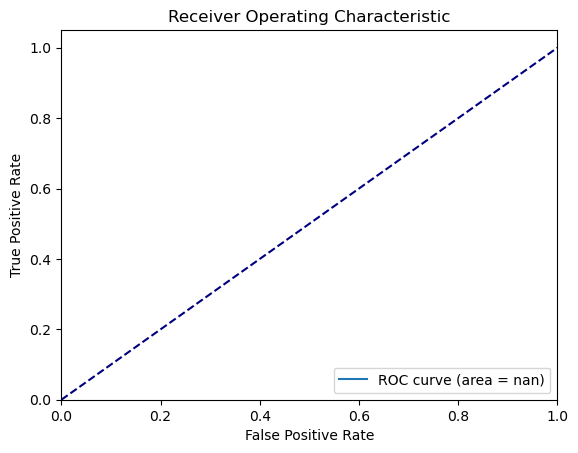

In [34]:
evaluate.draw_auc_roc(Aws, PreA)

In [44]:
IMatrix= torch.eye(100, device= "cpu")
identicalf= 0.01

cosinesNp= []
spectralsNp= []
edgesNp= []
jaccardsNp= []
hammingNp= []
#Performance on different dense

for randomGraph in randomGraphs:
    cosinesList= []
    spectralsList= []
    edgesList= []
    jaccardsList= []
    hammingList= []
    for dense in denses:
        cosines= 0
        spectrals= 0
        edges= 0
        jaccards= 0
        hammings= 0
        for seed in seeds:
            try:
                fileName= f"results/AA/AA_{randomGraph}_identical_{seed}_{4}_-1_{dense}_{100}_{identicalf*1000}_150000.npz"
                npzfile = np.load(fileName)
                # Access the arrays in the NPZ file
                Awnp= npzfile['A']
                PreAnp= npzfile['Apre']
            except:
                print(fileName)
                pass
            Aw = torch.tensor(Awnp)
            PreA = torch.tensor(PreAnp)
            links= int(torch.sum(Aw)/identicalf)  
            Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
            PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))+IMatrix
            cosines+= evaluate.cosine_similarity(Aw, PreA)
            spectrals+= evaluate.spectral_analysis(Aw, PreA)
            edges+= evaluate.recall(Aws, PreAs)
            jaccards+= evaluate.jaccard_index(Aws, PreAs)
            hammings+= evaluate.normalized_hamming_distance(Aws, PreAs)
        cosines/= len(seeds)
        spectrals/= len(seeds)
        edges/= len(seeds)
        jaccards/= len(seeds)
        hammings/= len(seeds)
        cosinesList.append(f"{cosines:.2f}")
        spectralsList.append(f"{spectrals:.2f}")
        edgesList.append(f"{edges:.2f}")
        jaccardsList.append(f"{jaccards:.2f}")
        hammingList.append(f"{hammings:.2f}")
        #print(f"{cosines:.2f}\t{spectrals:.2f}\t{edges:.2f}\t{jaccards:.2f}", end="\t")
    print("\t".join(cosinesList)+"\t"+"\t".join(spectralsList)+"\t"+"\t".join(edgesList)+"\t"+"\t".join(jaccardsList)+"\t"+"\t".join(hammingList))
    cosinesNp.append([float(i) for i in cosinesList])
    spectralsNp.append([float(i) for i in spectralsList])
    edgesNp.append([float(i) for i in edgesList])
    jaccardsNp.append([float(i) for i in jaccardsList])
    hammingNp.append([float(i) for i in hammingList])
    #print()
cosinesNp= np.array(cosinesNp).astype(float)
spectralsNp= np.array(spectralsNp).astype(float)
edgesNp= np.array(edgesNp).astype(float)
jaccardsNp= np.array(jaccardsNp).astype(float)
hammingNp= np.array(hammingNp).astype(float)

0.65	0.62	0.60	0.61	0.61	0.20	0.22	0.32	0.23	0.41	0.60	0.57	0.53	0.53	0.53	0.43	0.40	0.36	0.36	0.36	0.27	0.31	0.35	0.38	0.40
0.74	0.68	0.69	0.68	0.67	0.21	0.38	0.43	0.49	0.47	0.72	0.64	0.65	0.63	0.61	0.56	0.47	0.48	0.46	0.44	0.22	0.28	0.29	0.32	0.35
0.89	0.88	0.86	0.84	0.83	0.78	0.75	0.83	0.82	0.83	0.91	0.89	0.87	0.85	0.84	0.83	0.81	0.78	0.74	0.72	0.13	0.15	0.18	0.21	0.24
0.96	0.96	0.96	0.95	0.94	0.83	0.83	0.84	0.88	0.90	0.97	0.98	0.98	0.98	0.97	0.94	0.96	0.96	0.96	0.95	0.07	0.06	0.06	0.08	0.09


In [45]:
print(denses)
print(hammingNp)

[0, -1, -2, -3, -4]
[[0.27 0.31 0.35 0.38 0.4 ]
 [0.22 0.28 0.29 0.32 0.35]
 [0.13 0.15 0.18 0.21 0.24]
 [0.07 0.06 0.06 0.08 0.09]]


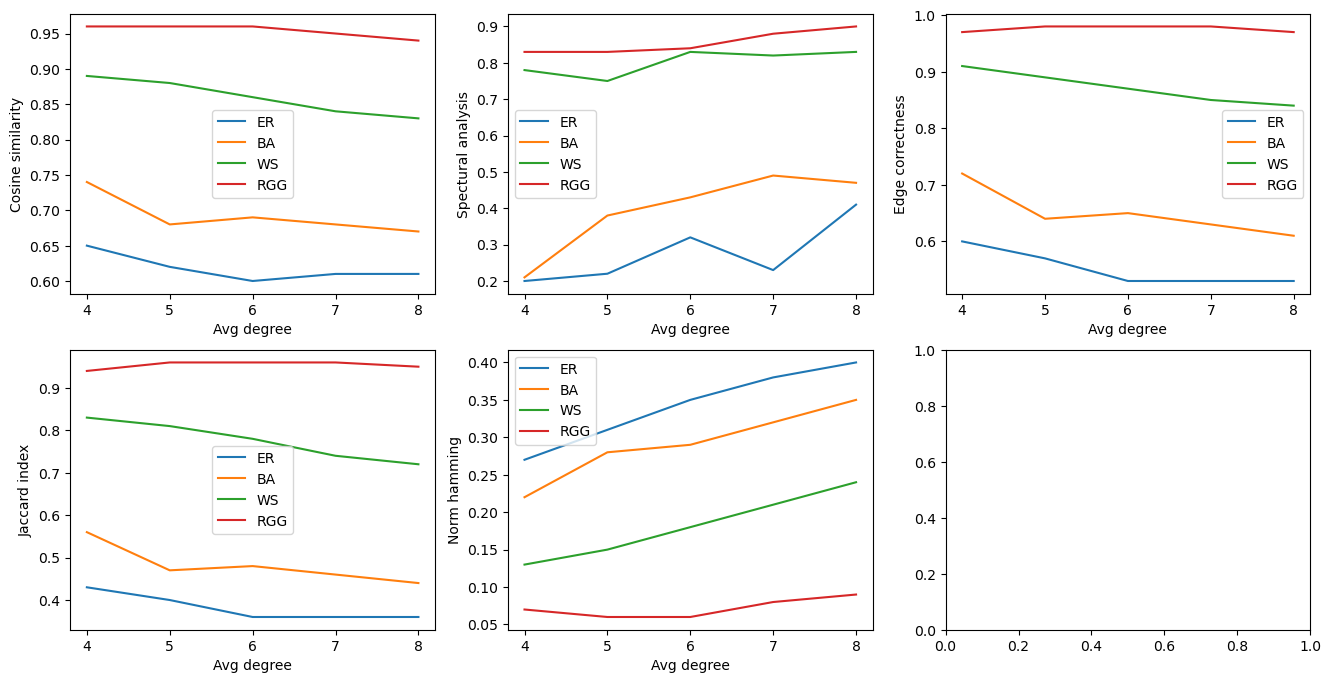

In [46]:
fig, axs = plt.subplots(2, 3, figsize=(16, 8))
import math 
axs[0, 0].plot(int(math.log(100))-np.array(denses) ,cosinesNp.T)
axs[0, 0].set_ylabel('Cosine similarity')
axs[0, 0].set_xlabel("Avg degree")
axs[0, 0].legend(["ER", "BA", "WS", "RGG"])


axs[0, 1].plot(int(math.log(100))-np.array(denses) ,spectralsNp.T)
axs[0, 1].set_ylabel('Spectural analysis')
axs[0, 1].set_xlabel("Avg degree")
axs[0, 1].legend(["ER", "BA", "WS", "RGG"])

axs[0, 2].plot(int(math.log(100))-np.array(denses) ,edgesNp.T)
axs[0, 2].set_ylabel('Edge correctness')
axs[0, 2].set_xlabel("Avg degree")
axs[0, 2].legend(["ER", "BA", "WS", "RGG"])

axs[1, 0].plot(int(math.log(100))-np.array(denses) ,jaccardsNp.T)
axs[1, 0].set_ylabel('Jaccard index')
axs[1, 0].set_xlabel("Avg degree")
axs[1, 0].legend(["ER", "BA", "WS", "RGG"])


axs[1, 1].plot(int(math.log(100))-np.array(denses) ,hammingNp.T)
axs[1, 1].set_ylabel('Norm hamming')
axs[1, 1].set_xlabel("Avg degree")
axs[1, 1].legend(["ER", "BA", "WS", "RGG"])

In [21]:
def normalized_hamming_distance(predicted_matrix, true_matrix):
    """Calculates the Normalized Hamming Distance between two matrices."""

    assert predicted_matrix.shape == true_matrix.shape, "Matrices must have the same shape."
    num_nodes = predicted_matrix.shape[0]
    max_distance = num_nodes * (num_nodes - 1)   # Maximum possible distance for a full matrix

    hamming_distance = np.sum(np.logical_xor(predicted_matrix, true_matrix)) #01, 10, (11, 00)
    normalized_distance = np.sqrt(hamming_distance /max_distance)

    return normalized_distance

identicalf= 0.01
random.seed(100002)

#Performance on different node number
CompareWithRandom= False

for randomGraph in randomGraphs:
    cosinesList= []
    spectralsList= []
    edgesList= []
    jaccardsList= []
    hammingList= []
    for node in nodes:
        cosines= 0
        spectrals= 0
        edges= 0
        jaccards= 0
        hammings= 0
        for seed in seeds:
            fileName= f"results/AA/AA_{randomGraph}_identical_{seed}_{4}_-1_0_{node}_{0.01*1000}_150000.npz"
            IMatrix= torch.eye(node, device= "cpu")
            npzfile = np.load(fileName)
            # Access the arrays in the NPZ file
            Awnp= npzfile['A']
            PreAnp= npzfile['Apre']
            dense= int(math.log(node))
            if CompareWithRandom:
                A, _= random_graph.get_ER_random_contact(node, dense, shuffle= True)
                PreAnp= A.numpy()
            Aw = torch.tensor(Awnp)
            PreA = torch.tensor(PreAnp)
            links= int(torch.sum(Aw)/identicalf)  
            Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
            PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))+IMatrix
            cosines+= evaluate.cosine_similarity(Aw, PreA)
            spectrals+= evaluate.spectral_analysis(Aw, PreA)
            edges+= evaluate.recall(Aws, PreAs)
            jaccards+= evaluate.jaccard_index(Aws, PreAs)
            hammings+= evaluate.normalized_hamming_distance(Aws, PreAs)
        cosines/= len(seeds)
        spectrals/= len(seeds)
        edges/= len(seeds)
        jaccards/= len(seeds)
        hammings/= len(seeds)
        cosinesList.append(f"{cosines:.2f}")
        spectralsList.append(f"{spectrals:.2f}")
        edgesList.append(f"{edges:.2f}")
        jaccardsList.append(f"{jaccards:.2f}")
        hammingList.append(f"{hammings:.2f}")
        #print(f"{cosines:.2f}\t{spectrals:.2f}\t{edges:.2f}\t{jaccards:.2f}", end="\t")
    print("\t".join(cosinesList)+"\t"+"\t".join(spectralsList)+"\t"+"\t".join(edgesList)+"\t"+"\t".join(jaccardsList)+"\t"+"\t".join(hammingList))
    #print()


0.87	0.65	0.50	0.38	0.18	0.20	0.12	0.21	0.86	0.60	0.45	0.34	0.76	0.43	0.29	0.20	0.20	0.27	0.25	0.19
0.88	0.74	0.58	0.50	0.45	0.21	0.12	0.22	0.89	0.72	0.55	0.47	0.80	0.56	0.38	0.31	0.17	0.22	0.22	0.17
0.97	0.89	0.79	0.74	0.76	0.78	0.76	0.68	0.98	0.91	0.79	0.73	0.97	0.83	0.65	0.58	0.06	0.13	0.15	0.12
0.98	0.96	0.94	0.92	0.90	0.83	0.77	0.78	0.99	0.97	0.95	0.93	0.98	0.94	0.92	0.88	0.06	0.07	0.07	0.06


In [50]:

identicalf= 0.01
node= 100
#Performance on different intense

for randomGraph in randomGraphs:
    cosinesList= []
    spectralsList= []
    edgesList= []
    jaccardsList= []
    hammingList= []
    for intense in intenses:
        cosines= 0
        spectrals= 0
        edges= 0
        jaccards= 0
        hammings= 0
        for seed in seeds:
            fileName= f"results/AA/AA_{randomGraph}_identical_{seed}_{4}_{intense}_0_{node}_{0.01*1000}_150000.npz"
            IMatrix= torch.eye(node, device= "cpu")
            npzfile = np.load(fileName)
            # Access the arrays in the NPZ file
            Awnp= npzfile['A']
            PreAnp= npzfile['Apre']
            Aw = torch.tensor(Awnp)
            PreA = torch.tensor(PreAnp)
            links= int(torch.sum(Aw)/identicalf)  
            Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
            PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))+IMatrix
            cosines+= evaluate.cosine_similarity(Aw, PreA)
            spectrals+= evaluate.spectral_analysis(Aw, PreA)
            edges+= evaluate.recall(Aws, PreAs)
            jaccards+= evaluate.jaccard_index(Aws, PreAs)
            hammings+= evaluate.normalized_hamming_distance(Aws, PreAs)
        cosines/= len(seeds)
        spectrals/= len(seeds)
        edges/= len(seeds)
        jaccards/= len(seeds)
        hammings/= len(seeds)
        cosinesList.append(f"{cosines:.2f}")
        spectralsList.append(f"{spectrals:.2f}")
        edgesList.append(f"{edges:.2f}")
        jaccardsList.append(f"{jaccards:.2f}")
        hammingList.append(f"{hammings:.2f}")
        #print(f"{cosines:.2f}\t{spectrals:.2f}\t{edges:.2f}\t{jaccards:.2f}", end="\t")
    print("\t".join(cosinesList)+"\t"+"\t".join(spectralsList)+"\t"+"\t".join(edgesList)+"\t"+"\t".join(jaccardsList)+"\t"+"\t".join(hammingList))
    #print()


0.66	0.66	0.64	0.65	0.25	0.19	0.21	0.20	0.62	0.62	0.60	0.60	0.45	0.45	0.43	0.43	0.26	0.26	0.27	0.27
0.75	0.75	0.74	0.74	0.30	0.37	0.28	0.21	0.73	0.73	0.71	0.72	0.58	0.58	0.56	0.56	0.22	0.22	0.22	0.22
0.89	0.90	0.90	0.89	0.72	0.73	0.77	0.78	0.90	0.92	0.92	0.91	0.83	0.84	0.84	0.83	0.13	0.12	0.12	0.13
0.97	0.97	0.95	0.96	0.86	0.82	0.82	0.83	0.98	0.98	0.96	0.97	0.96	0.97	0.92	0.94	0.05	0.05	0.09	0.07


In [48]:
#AA_WS_identical_11_4_-1_0_100_10.0_150000
cosinesNp= []
spectralsNp= []
edgesNp= []
jaccardsNp= []
hammingNp= []
identicalf= 0.01
node= 100
#Performance on different identicalf new

for randomGraph in randomGraphs:
    cosinesList= []
    spectralsList= []
    edgesList= []
    jaccardsList= []
    hammingList= []
    for identicalf in identicalfs:
        cosines= 0
        spectrals= 0
        edges= 0
        jaccards= 0
        hammings= 0
        for seed in seeds:
            fileName= f"results/AA/AA_{randomGraph}_identical_{seed}_{4}_-1_0_{node}_{identicalf*1000}_150000.npz"
            IMatrix= torch.eye(node, device= "cpu")
            npzfile = np.load(fileName)
            # Access the arrays in the NPZ file
            Awnp= npzfile['A']
            PreAnp= npzfile['Apre']
            Aw = torch.tensor(Awnp)
            PreA = torch.tensor(PreAnp)
            links= int(torch.sum(Aw)/identicalf)  
            Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
            PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))+IMatrix
            cosines+= evaluate.cosine_similarity(Aw, PreA)
            spectrals+= evaluate.spectral_analysis(Aw, PreA)
            edges+= evaluate.recall(Aws, PreAs)
            jaccards+= evaluate.jaccard_index(Aws, PreAs)
            hammings+= evaluate.normalized_hamming_distance(Aws, PreAs)
        cosines/= len(seeds)
        spectrals/= len(seeds)
        edges/= len(seeds)
        jaccards/= len(seeds)
        hammings/= len(seeds)
        cosinesList.append(f"{cosines:.2f}")
        spectralsList.append(f"{spectrals:.2f}")
        edgesList.append(f"{edges:.2f}")
        jaccardsList.append(f"{jaccards:.2f}")
        hammingList.append(f"{hammings:.2f}")
        #print(f"{cosines:.2f}\t{spectrals:.2f}\t{edges:.2f}\t{jaccards:.2f}", end="\t")
    print("\t".join(cosinesList)+"\t"+"\t".join(spectralsList)+"\t"+"\t".join(edgesList)+"\t"+"\t".join(jaccardsList)+"\t"+"\t".join(hammingList))
    cosinesNp.append([float(i) for i in cosinesList])
    spectralsNp.append([float(i) for i in spectralsList])
    edgesNp.append([float(i) for i in edgesList])
    jaccardsNp.append([float(i) for i in jaccardsList])
    hammingNp.append([float(i) for i in hammingList])
    #print()
cosinesNp= np.array(cosinesNp).astype(float)
spectralsNp= np.array(spectralsNp).astype(float)
edgesNp= np.array(edgesNp).astype(float)
jaccardsNp= np.array(jaccardsNp).astype(float)
hammingNp= np.array(hammingNp).astype(float)

0.58	0.62	0.66	0.67	0.66	0.65	0.64	0.62	0.29	0.22	0.25	0.17	0.20	0.19	0.20	0.24	0.19	0.24	0.55	0.59	0.62	0.63	0.63	0.60	0.59	0.57	0.40	0.38	0.42	0.46	0.46	0.46	0.43	0.42	0.40	0.25	0.29	0.27	0.26	0.26	0.26	0.27	0.27	0.28	0.33
0.62	0.70	0.71	0.74	0.74	0.74	0.74	0.56	0.28	0.34	0.30	0.30	0.20	0.30	0.21	0.30	0.21	0.25	0.61	0.69	0.70	0.72	0.72	0.72	0.71	0.64	0.43	0.44	0.52	0.54	0.57	0.56	0.56	0.55	0.48	0.27	0.26	0.23	0.23	0.22	0.22	0.22	0.22	0.25	0.32
0.81	0.88	0.90	0.91	0.90	0.89	0.88	0.88	0.75	0.72	0.76	0.76	0.79	0.75	0.78	0.76	0.76	0.77	0.82	0.89	0.92	0.93	0.91	0.91	0.89	0.89	0.81	0.70	0.80	0.85	0.86	0.84	0.83	0.80	0.80	0.68	0.18	0.14	0.12	0.12	0.12	0.13	0.14	0.14	0.19
0.89	0.93	0.94	0.96	0.95	0.96	0.95	0.94	0.39	0.78	0.82	0.80	0.82	0.84	0.83	0.84	0.85	0.59	0.89	0.94	0.94	0.96	0.96	0.97	0.96	0.96	0.67	0.81	0.89	0.89	0.93	0.92	0.94	0.93	0.92	0.51	0.13	0.10	0.10	0.08	0.08	0.07	0.08	0.08	0.24


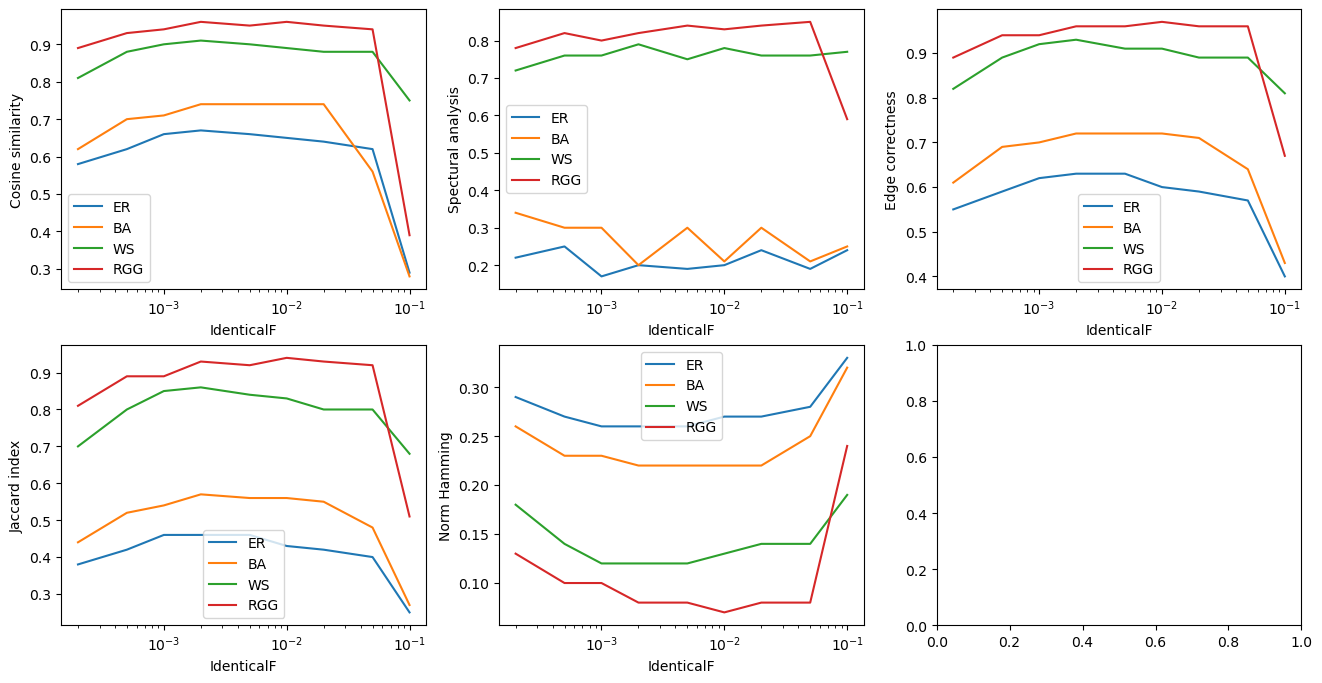

In [49]:
fig, axs = plt.subplots(2, 3, figsize=(16, 8))

axs[0, 0].plot(identicalfs ,cosinesNp.T)
axs[0, 0].set_ylabel('Cosine similarity')
axs[0, 0].set_xlabel("IdenticalF")
axs[0, 0].set_xscale('log')
axs[0, 0].legend(["ER", "BA", "WS", "RGG"])


axs[0, 1].plot(identicalfs ,spectralsNp.T)
axs[0, 1].set_ylabel('Spectural analysis')
axs[0, 1].set_xlabel("IdenticalF")
axs[0, 1].set_xscale('log')
axs[0, 1].legend(["ER", "BA", "WS", "RGG"])

axs[0, 2].plot(identicalfs ,edgesNp.T)
axs[0, 2].set_ylabel('Edge correctness')
axs[0, 2].set_xlabel("IdenticalF")
axs[0, 2].set_xscale('log')
axs[0, 2].legend(["ER", "BA", "WS", "RGG"])

axs[1, 0].plot(identicalfs ,jaccardsNp.T)
axs[1, 0].set_ylabel('Jaccard index')
axs[1, 0].set_xlabel("IdenticalF")
axs[1, 0].set_xscale('log')
axs[1, 0].legend(["ER", "BA", "WS", "RGG"])


axs[1, 1].plot(identicalfs ,hammingNp.T)
axs[1, 1].set_ylabel('Norm Hamming')
axs[1, 1].set_xlabel("IdenticalF")
axs[1, 1].set_xscale('log')
axs[1, 1].legend(["ER", "BA", "WS", "RGG"])